(continuous_hgf)=
# The continuous Hierarchical Gaussian Filter

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ComputationalPsychiatry/pyhgf/blob/master/docs/source/notebooks/1.3-Continuous_HGF.ipynb)

In [1]:
import sys
from IPython.utils import io
if 'google.colab' in sys.modules:

  with io.capture_output() as captured:
      ! pip install pyhgf watermark

In [2]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pymc as pm

from pyhgf import load_data
from pyhgf.distribution import HGFDistribution
from pyhgf.model import HGF, Network
from pyhgf.response import first_level_gaussian_surprise

plt.rcParams["figure.constrained_layout.use"] = True

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In this notebook, we illustrate applications of the standard two-level and three-level Hierarchical Gaussian Filters (HGF) for continuous inputs. This class of models slightly differs from the previous binary example as input nodes here are not restricted to boolean variables but accept any observations on a continuous domain. Fitting continuous data allows using the HGF with any time series, which can find several applications in neuroscience (see for example the case study on physiological modelling using the Hierarchical Gaussian Filter {ref}`example_1`). The continuous HGF is built on to of the following probabilistic networks:

```{figure} ../images/continuous.svg
---
name: continuous-hgf
---
The two-level and three-level Hierarchical Gaussian Filter for continuous inputs. All nodes are continuous state nodes. The first node ($x_0$) can observe new values.
```

Here, we will use the continuous HGF to predict the exchange rate of the US Dollar to the Swiss Franc during much of 2010 and 2011 (we use this time series as it is a classical example in the [Matlab toolbox)](https://github.com/translationalneuromodeling/tapas/blob/master/HGF/README.md).

In [3]:
timeserie = load_data("continuous")

## Fitting the continuous HGF with fixed parameters
### The two-level continuous Hierarchical Gaussian Filter
#### Create the model

```{note}
The default response function for a continuous HGF is the [sum of the Gaussian surprise at the first level](pyhgf.response.total_gaussian_surprise). In other words, at each time point the model try to update its hierarchy to minimize the discrepancy between the expected and real next observation in the continuous domain.
```

In [4]:
two_levels_continuous_hgf = (
    Network()
    .add_nodes(precision=1e4)
    .add_nodes(precision=1e4, mean=timeserie[0], tonic_volatility=-13.0, value_children=0)
    .add_nodes(precision=1e1, tonic_volatility=-2.0, volatility_children=1)
)

This function creates an instance of an HGF model automatically parametrized for a two-level continuous structure, so we do not have to worry about creating the node structure ourselves. This class also embed function to add new observations and plots results of network structure. We can visualize the node structure using the {py:func}`pyhgf.plots.plot_network` function that will draw the nodes [Graphviz](https://github.com/xflr6/graphviz).

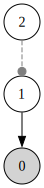

In [5]:
two_levels_continuous_hgf.plot_network()

#### Add data

In [6]:
# Provide new observations
two_levels_continuous_hgf = two_levels_continuous_hgf.input_data(input_data=timeserie)

#### Plot trajectories

A Hierarchical Gaussian Filter parametrized with the standard Gaussian surprise as a response function will act as a Bayesian filter. By presenting new continuous observations and running the update equation forward, we can observe the trajectories of the parameters of the node that are adapting to the trajectory and volatility of the input time series (i.e. the mean $\mu$ and the precision $\pi$). The `plot_trajectories` function automatically extracts the relevant parameters given the model structure and plots their evolution together with the input data.

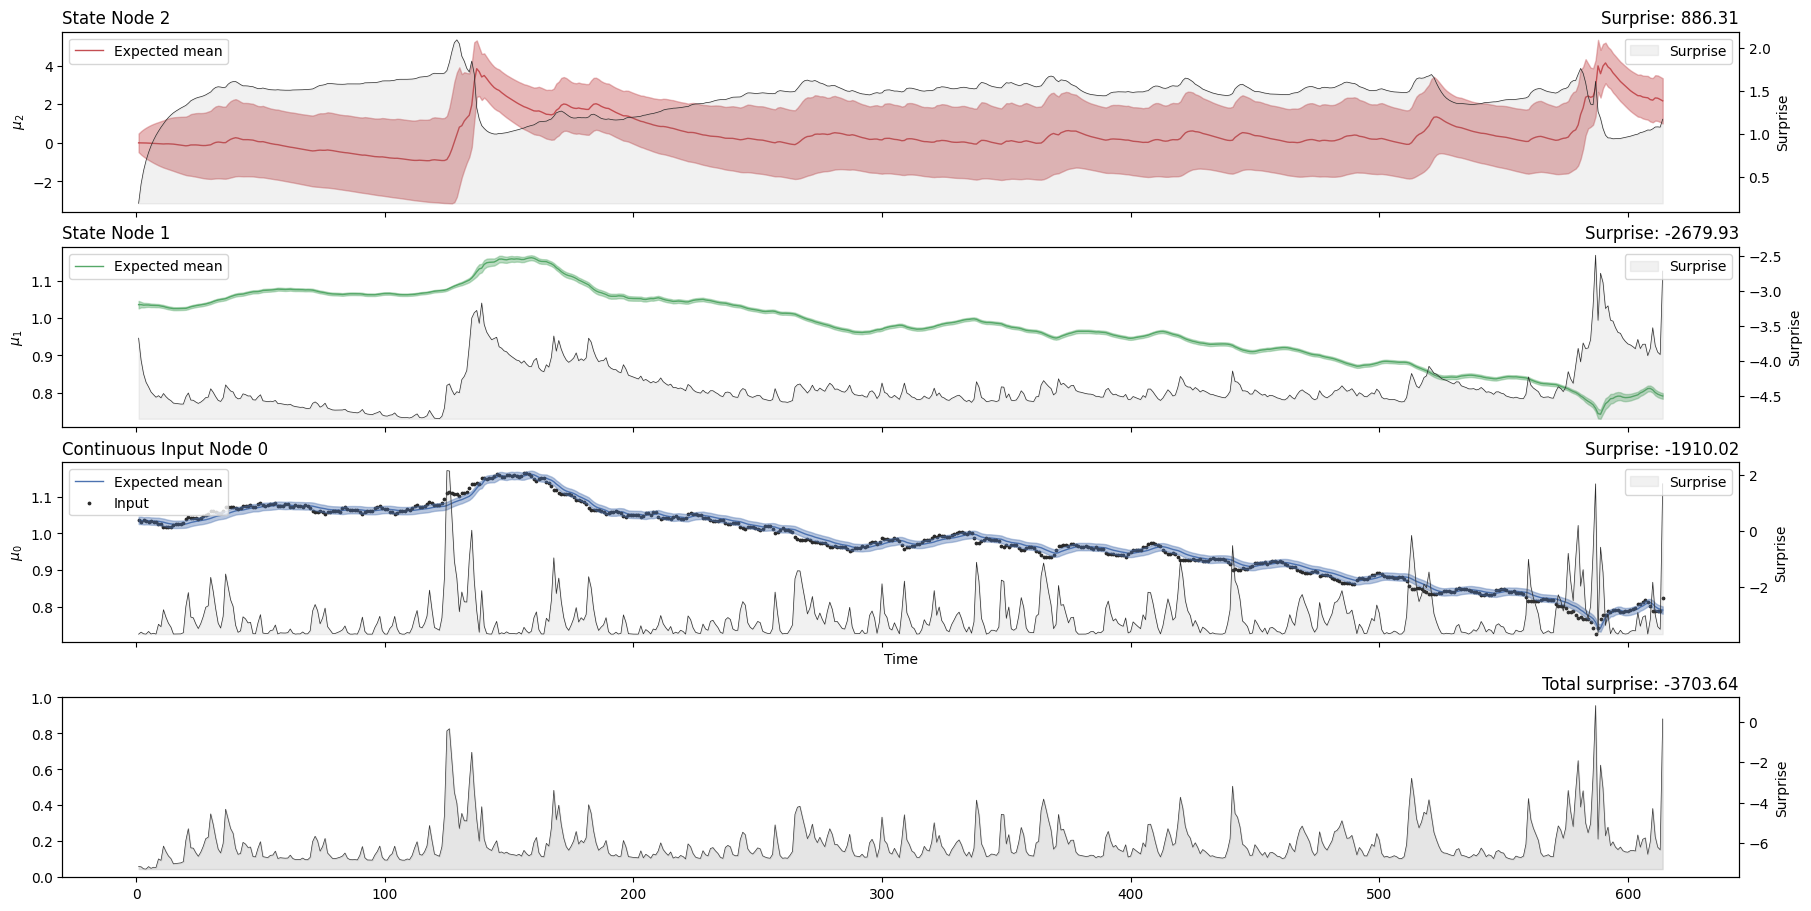

In [7]:
two_levels_continuous_hgf.plot_trajectories(show_total_surprise=True);

In [8]:
# ensure that the results are valid
df = two_levels_continuous_hgf.to_pandas()
assert jnp.isclose(df.x_0_surprise.sum(), -1910.0183)
assert jnp.isclose(df.x_1_surprise.sum(), -2679.9297)
assert jnp.isclose(df.x_2_surprise.sum(), 886.30963)

Looking at the volatility level (i.e. the orange line in the first panel), we see that there are two salient events in our time series where volatility shoots up. The first was in April 2010 when the currency markets reacted to the news that Greece was effectively broken. This leads to a flight into the US dollar (the grey dots rising very quickly), sending the volatility higher. The second is an accelerating increase in the value of the Swiss Franc in August and September 2011, as the Euro crisis dragged on. The point where the Swiss central bank intervened and put a floor under how far the Euro could fall with respect to the Franc is visible in Franc's valuation against the Dollar. This surprising intervention shows up as another spike in volatility.

We can see that the surprise will increase when the time series exhibits more unexpected behaviours. The degree to which a given observation is expected will depend on the expected value and volatility in the input node, which is influenced by the values of higher-order nodes. One way to assess model fit is to look at the total Gaussian surprise for each observation. This value can be returned using the {py:meth}`pyhgf.model.HGF.surprise` method:

In [9]:
two_levels_continuous_hgf.surprise(response_function=first_level_gaussian_surprise).sum()

Array(-886.6174, dtype=float32)

```{note}
The surprise returned by a model when presented with new observations is a function of the response model that was used. Different response functions can be added and provided, together with additional parameters in the {py:meth}`pyhgf.model.HGF.surprise` method. The surprise is the negative log probability density of the new observations under the model priors:

$$surprise = -log(p)$$
```

#### Plot correlation
Node parameters that are highly correlated across time are likely to indicate that the model did not learn hierarchical structure in the data but instead overfitted on some components. One way to quickly check the parameters nodes correlation is to use the `plot_correlation` function embedded in the HGF class.

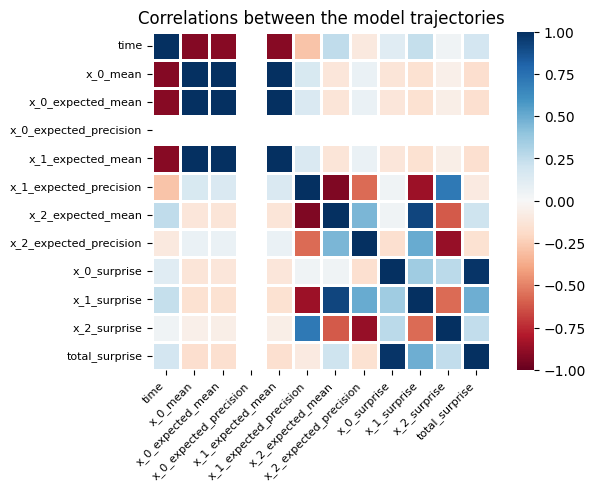

In [10]:
two_levels_continuous_hgf.plot_correlations();

### The three-level continuous Hierarchical Gaussian Filter
#### Create the model
The three-level HGF can add a meta-volatility layer to the model. This can be useful if we suspect that the volatility of the time series is not stable across time and we would like our model to learn it. Here, we create a new {py:class}`pyhgf.model.HGF` instance, setting the number of levels to `3`. Note that we are extending the size of the dictionaries accordingly.

In [11]:
three_levels_continuous_hgf = HGF(
    n_levels=3,
    model_type="continuous",
    initial_mean={"1": 1.04, "2": 0.0, "3": 0.0},
    initial_precision={"1": 1e4, "2": 1.0, "3": 1.0},
    tonic_volatility={"1": -13.0, "2": -2.0, "3": -2.0}
)

The node structure now includes a volatility parent at the third level.

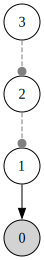

In [12]:
three_levels_continuous_hgf.plot_network()

#### Add data

In [13]:
three_levels_continuous_hgf = three_levels_continuous_hgf.input_data(input_data=timeserie)

#### Plot trajectories

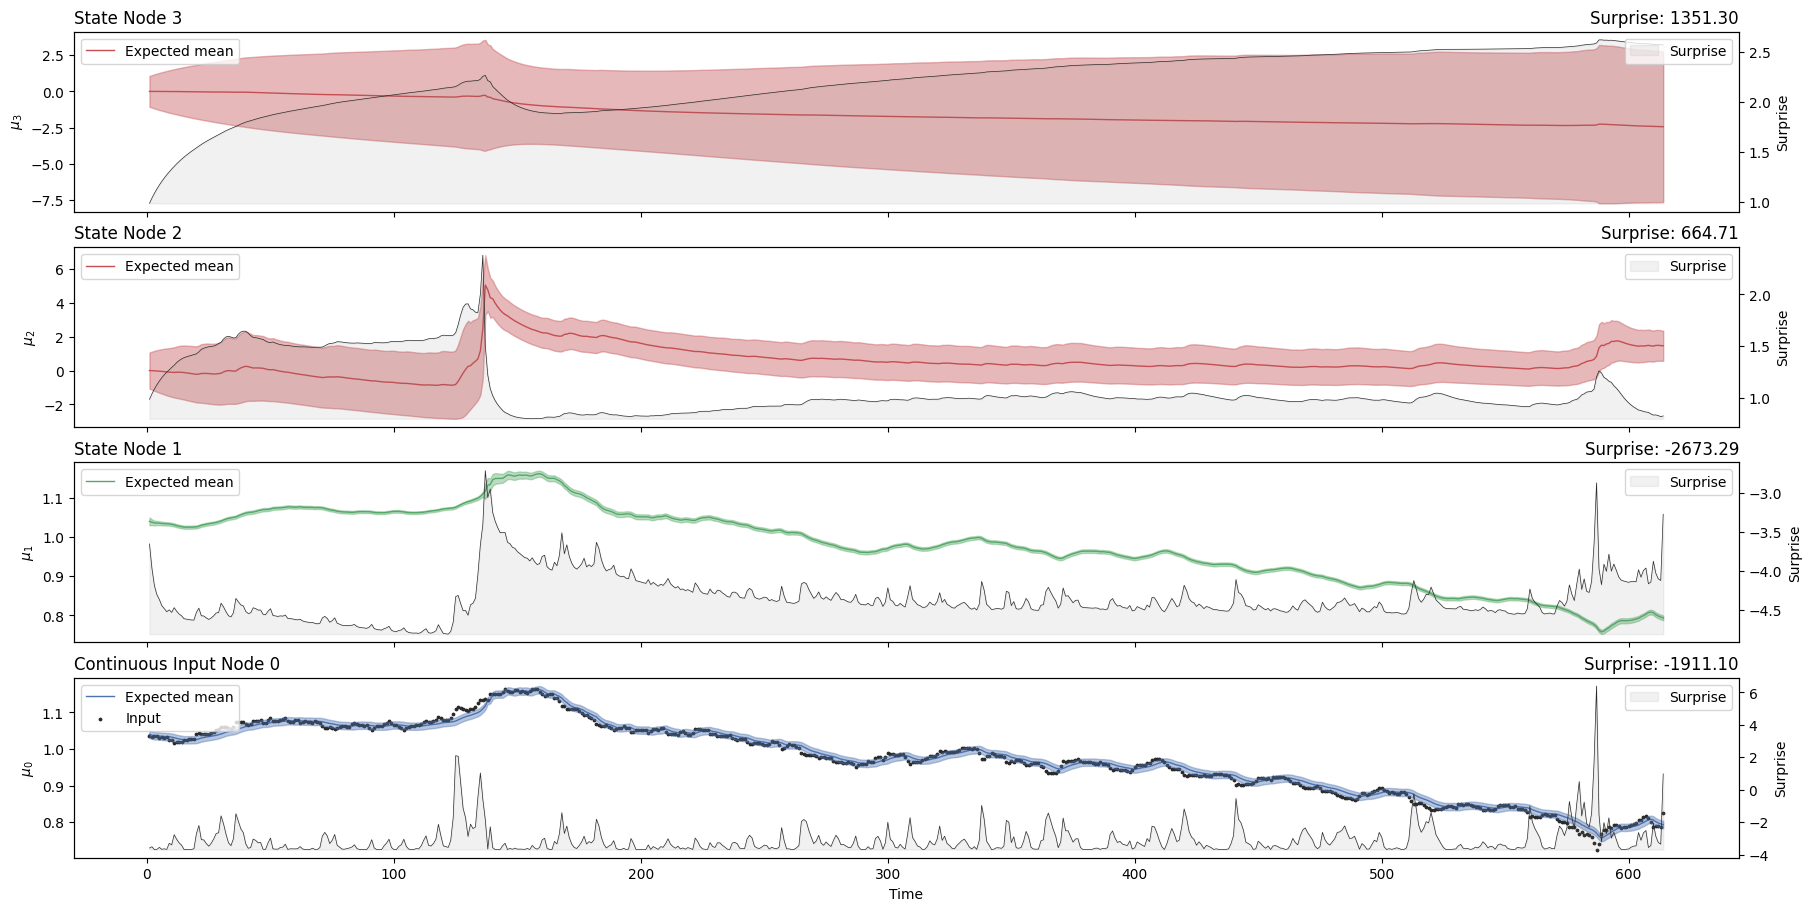

In [14]:
three_levels_continuous_hgf.plot_trajectories();

#### Surprise
Similarly, we can retrieve the overall Gaussian surprise at the first node for each new observation using the built-in method:

In [15]:
three_levels_continuous_hgf.surprise().sum()

Array(-903.4093, dtype=float32)

The overall amount of surprise returned by the three-level HGF is quite similar to what was observed with the two-level model (`-964` vs.`-965`). Because an agent will aim to minimize surprise, it looks like the two-level model is slightly better in this context. However, the surprise will also change as the value for the parameters of the node is optimized beforehand. One important parameter for each node is the tonic volatility (sometimes noted $\omega$). This is the tonic part of the variance (the part of the variance in each node that is not affected by the parent node). Here we are going to change the tonic volatility at the second level to see if it can help to minimize surprise:

In [16]:
# create an alternative model with different omega values
# the input time series is passed in the same call
three_levels_continuous_hgf_bis = HGF(
    n_levels=3,
    model_type="continuous",
    initial_mean={"1": 1.04, "2": 0.0, "3": 0.0},
    initial_precision={"1": 1e4, "2": 1e1, "3": 1e1},
    tonic_volatility={"1": -13.0, "2": -1.0, "3": -2.0},
).input_data(input_data=timeserie)

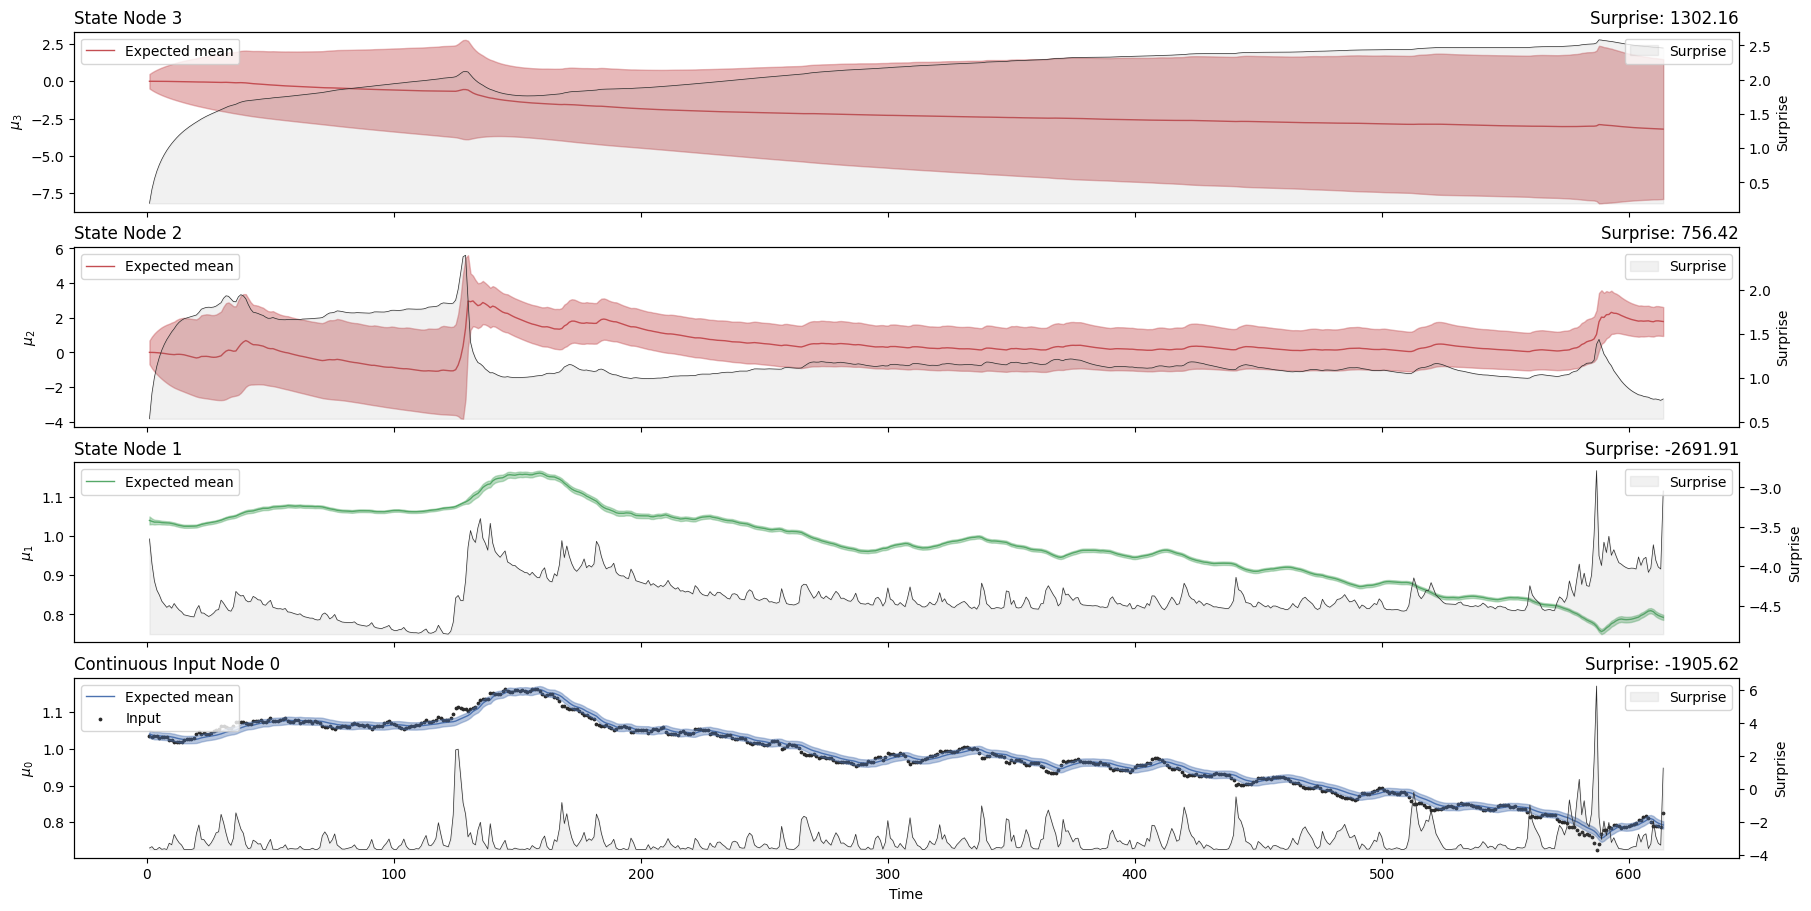

In [17]:
three_levels_continuous_hgf_bis.plot_trajectories();

In [18]:
three_levels_continuous_hgf_bis.surprise().sum()

Array(-828.69806, dtype=float32)

Now we are getting a global surprise of `-828` with the new model, as compared to a global surprise of `-910` before. It looks like the $\omega$ value at the second level can play an important role in minimizing surprise for this kind of time series. But how can we decide on which value to choose? Doing this by trial and error would be a bit tedious. Instead, we can use dedicated Bayesian methods that will infer the values of $\omega$ that minimize the surprise (i.e. that maximize the likelihood of the new observations given parameter priors).

## Learning parameters with MCMC sampling
In the previous section, we assumed we knew the parameters of the HGF models beforehand. This can give us information on how an agent using these values would have behaved when presented with these inputs. We can also adopt a different perspective and consider that we want to learn these parameters from the data, and then ask what would be the best parameter values for an agent to minimize surprises when presented with this data. Here, we are going to set priors over some parameters and use Hamiltonian Monte Carlo methods (NUTS) to sample their probability density.

Because the HGF classes are built on the top of [JAX](https://github.com/google/jax), they are natively differentiable and compatible with optimisation libraries. Here, we use [PyMC](https://www.pymc.io/welcome.html) to perform MCMC sampling. PyMC can use any log probability function (here the negative surprise of the model) as a building block for a new distribution by wrapping it in its underlying tensor library [Aesara](https://aesara.readthedocs.io/en/latest/), now [PyTensor](https://pytensor.readthedocs.io/en/latest/). pyhgf includes a PyMC-compatible distribution that can do this automatically{py:class}`pyhgf.distribution.HGFDistribution`.

### Two-level model
#### Creating the model

```{note}
The HGF distribution class {py:class}`pyhgf.distribution.HGFDistribution` uses the [first level Gaussian surprise](pyhgf.response.first_level_gaussian_surprise) (i.e. the sum of the Gaussian surprises at each new observation) as default response function, so adding this argument here is optional but is passed for clarity.
```

In [19]:
hgf_logp_op = HGFDistribution(
    n_levels=2,
    input_data=timeserie[jnp.newaxis, :],
    response_function=first_level_gaussian_surprise
)

This log probability function can then be embedded in a PyMC model using the same API. Here, we are going to optimize `omega_1`. The other parameters are fixed.

```{note}
The data has been passed to the distribution in the cell above when the function is created.
```

In [20]:
with pm.Model() as two_level_hgf:

    # Set a prior over the evolution rate at the first level.
    tonic_volatility_1 = pm.Normal("tonic_volatility_1", -10, 2.0)

    # Call the pre-parametrized HGF distribution here.
    # All parameters are set to their default value except omega_1, omega_2 and mu_1.
    pm.Potential(
        "hgf_loglike", hgf_logp_op(
            tonic_volatility_1=tonic_volatility_1, tonic_volatility_2=-2.0, mean_1=1.0
        )
    )

```{note}
The $\omega$ parameters are real numbers that are defined from -$\infty$ to +$\infty$. However, as learning rates are expressed in log spaces, values higher than 2 are extremely unlikely and could create aberrant fits to the data. Therefore, here we are using a prior that is centred on more reasonable values.
```

#### Visualizing the model

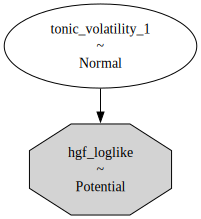

In [21]:
pm.model_to_graphviz(two_level_hgf)

#### Sampling

In [22]:
with two_level_hgf:
    two_level_hgf_idata = pm.sample(chains=2, cores=1)

Initializing NUTS using jitter+adapt_diag...


Sequential sampling (2 chains in 1 job)


NUTS: [tonic_volatility_1]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


We recommend running at least 4 chains for robust computation of convergence diagnostics


/tmp/ipykernel_19237/2516081684.py:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


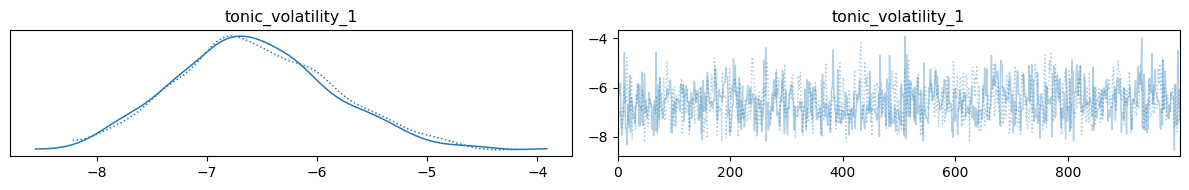

In [23]:
az.plot_trace(two_level_hgf_idata);
plt.tight_layout()

#### Using the learned parameters
We can see from the density distributions that the most probable values for $\omega_{1}$ are found around `-7`. To get an idea of the belief trajectories that are implied by such parameters, we can fit the model again using the most likely value directly from the sample:

In [24]:
tonic_volatility_1 = az.summary(two_level_hgf_idata)["mean"]["tonic_volatility_1"]

In [25]:
hgf_mcmc = HGF(
    n_levels=2,
    model_type="continuous",
    initial_mean={"1": timeserie[0], "2": 0.0},
    initial_precision={"1": 1e4, "2": 1e1},
    tonic_volatility={"1": tonic_volatility_1, "2": -2.0}).input_data(
        input_data=timeserie
    )

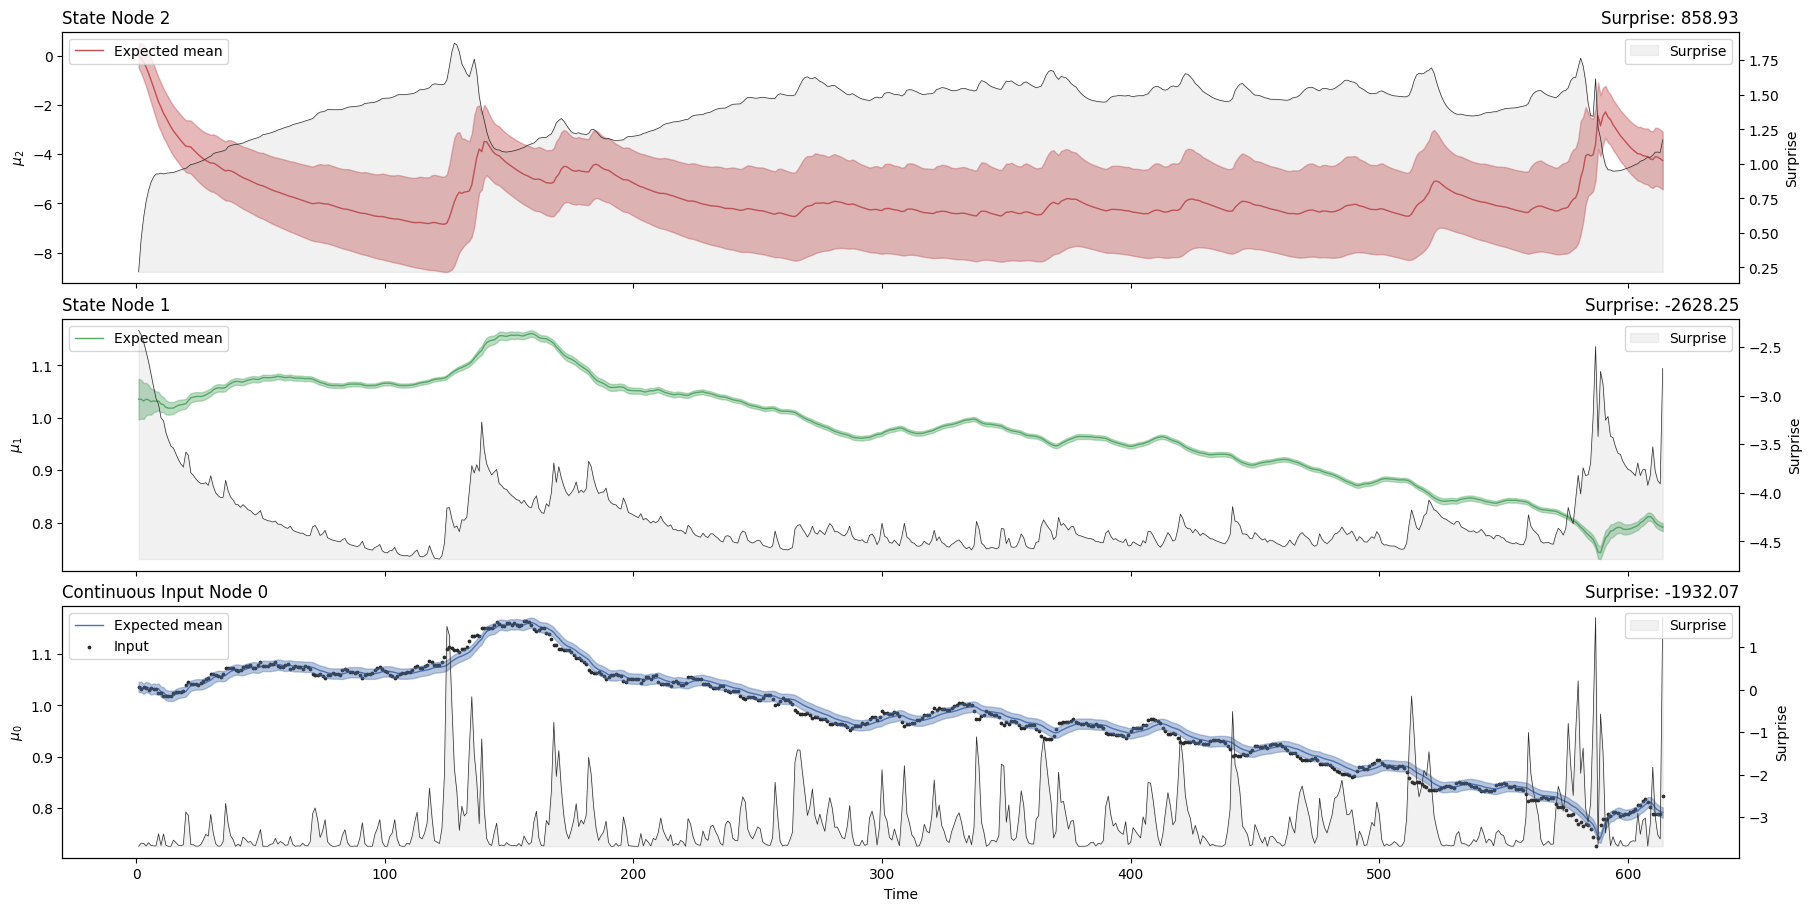

In [26]:
hgf_mcmc.plot_trajectories();

In [27]:
hgf_mcmc.surprise().sum()

Array(-1106.0715, dtype=float32)

### Three-level model
#### Creating the model

In [28]:
hgf_logp_op = HGFDistribution(
    n_levels=3,
    input_data=timeserie[jnp.newaxis, :]
)

In [29]:
with pm.Model() as three_level_hgf:

    # Set a prior over the evolution rate at the first level.
    tonic_volatility_1 = pm.Normal("tonic_volatility_1", -10, 2.0)

    # Call the pre-parametrized HGF distribution here.
    # All parameters are set to their default value except omega_1, omega_2, omega_3 and mu_1.
    pm.Potential(
        "hgf_loglike", hgf_logp_op(
            tonic_volatility_1=tonic_volatility_1, tonic_volatility_2=-2.0,
            tonic_volatility_3=-2.0, mean_1=1.0
        )
    )

#### Visualizing the model

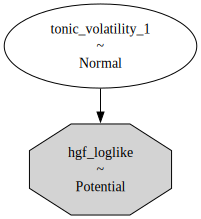

In [30]:
pm.model_to_graphviz(three_level_hgf)

#### Sampling

In [31]:
with three_level_hgf:
    three_level_hgf_idata = pm.sample(chains=2, cores=1)

Initializing NUTS using jitter+adapt_diag...


Sequential sampling (2 chains in 1 job)


NUTS: [tonic_volatility_1]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


We recommend running at least 4 chains for robust computation of convergence diagnostics


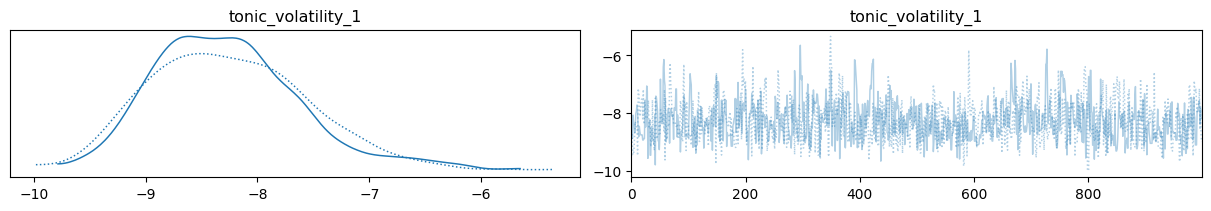

In [32]:
az.plot_trace(three_level_hgf_idata);

#### Using the learned parameters

In [33]:
tonic_volatility_1 = az.summary(three_level_hgf_idata)["mean"]["tonic_volatility_1"]

In [34]:
hgf_mcmc = HGF(
    n_levels=3,
    model_type="continuous",
    initial_mean={"1": timeserie[0], "2": 0.0, "3": 0.0},
    initial_precision={"1": 1e4, "2": 1e1, "3": 1e1},
    tonic_volatility={"1": tonic_volatility_1, "2": -2.0, "3": -2.0}).input_data(
        input_data=timeserie
    )

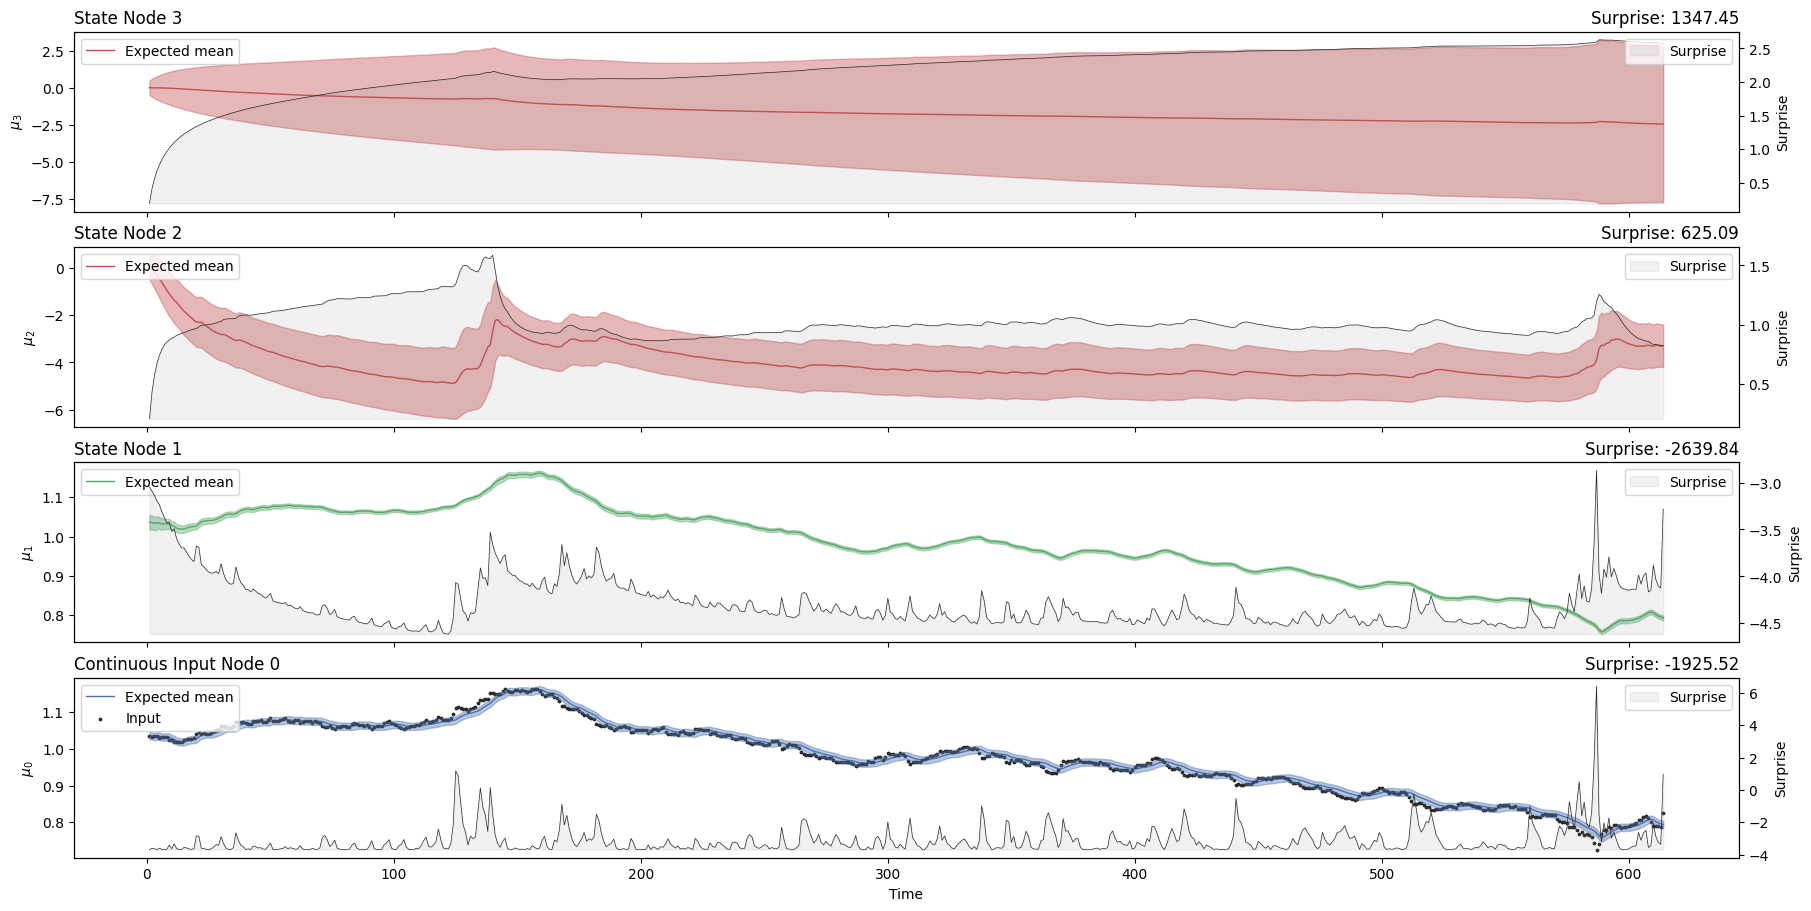

In [35]:
hgf_mcmc.plot_trajectories();

In [36]:
hgf_mcmc.surprise().sum()

Array(-1118.0437, dtype=float32)

## System configuration

In [37]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pyhgf,jax,jaxlib

Last updated: Sun May 11 2025

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 9.2.0

pyhgf : 0.2.6
jax   : 0.4.31
jaxlib: 0.4.31

pyhgf     : 0.2.6
jax       : 0.4.31
IPython   : 9.2.0
matplotlib: 3.10.1
arviz     : 0.21.0
sys       : 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:38:13) [GCC 12.3.0]
pymc      : 5.22.0

Watermark: 2.5.0

